# SQL Pipeline: Training Data

If today = `2019-08-16`:
1. `grp_gdoop_clv_db.eb_pip_deact_train_pop`: adds partition for today. Gets recency/frequency data from cia_realtime.user_attrs for each customer on `2018-08-15`. Keeps 7 days of data, drops other partitions.
2. `grp_gdoop_clv_db.eb_pip_deact_temp`: adds partition for today. Gets order, deal, financial info from me_orders_fgt_usd and campaign info from push_analytics.src_incentive_metrics for `2016-08-15` through `2018-08-14`. Partitioned by date, clustered by consumer_id. Keeps 7 days of data.
3. `grp_gdoop_clv_db.eb_pip_deact_response`: adds partition for today. Gets earliest order date for Groupon customers from me_orders_fgt_usd for `2018-08-15` through `2019-08-14`. Keeps 7 days of data.
4. `grp_gdoop_clv_db.eb_pip_deact_cookie_map1`: adds partition for today. Gets consumer ID to bcookie mapping from Step 1 from the partition for `2019-08-16`, and inner joins to user_groupondw.user_bcookie_mapping to find the most recent date for each bcookie during `2018-05-15` through `2018-08-14`. Keeps 7 days of data.
5. `grp_gdoop_clv_db.eb_pip_deact_cookie_map2`: adds partition for today. Gets consumer ID to bcookie mapping from Step 1 from the partition for `2019-08-16`, and inner joins to me_orders to find the most recent date for each bcookie during `2016-08-15` through `2018-08-14`. Keeps 7 days of data.
6. `grp_gdoop_clv_db.eb_pip_deact_cookie_map`: adds partition for today. Gets today's results from Step 4, union today's results from Step 5, taking the max of the latest bcookie dates if it shows up in both places. Keeps 7 days of data.
7. `grp_gdoop_clv_db.eb_pip_deact_engagement_temp`: adds partition for today. Gets frequency information by bcookie from user_groupondw.gbl_trafffic_superfunnel for `2018-05-15` through `2018-08-14`. Keeps 7 days of data.
8. `grp_gdoop_clv_db.eb_pip_deact_engagement_features`: adds partition for today. Gets today's results from Step 6, inner joined to today's results from Step 7, to match frequency information to consumer ID. Convert bcookie to count(bcookie) for each consumer ID, so table is 1 record per ID. Keeps 7 days of data.
9. `grp_gdoop_clv_db.eb_pip_consumer_lt_orders`: adds partition for today. Gets first and last purchase dates + count(distinct parent_order_key) from me_orders by consumer ID for orders BEFORE `2018-08-15`. Keeps 7 days of data.
10. `grp_gdoop_clv_db.deact_email_metrics`: adds partition for today. Gets today's results from Step 1 and inner joins to user_groupondw.agg_email to get email open and click info by consumer ID from `2018-07-16` through `2018-08-15` (30 days). Keeps 7 days of data.
11. `grp_gdoop_clv_db.eb_pip_deact_all_features`: adds partition for today. Gets today's results from Step 1, left join Step 3, left join Step 2, left join Step 8, left join Step 9, left join Step 10. Training population + recency/frequency + email metrics + order metrics + last purchase date. Randomly assigns 66% of records to 'training' and the rest to 'validation'. Keeps 7 days of data. ***USED AS MODEL TRAINING DATA.***
12. `grp_gdoop_clv_db.eb_pip_deact_training`: adds partition for today. Gets today's results from Step 11 where the population is training. Keeps 7 days of data.
13. `grp_gdoop_clv_db.eb_pip_deact_validation`: adds partition for today. Gets today's results from Step 11 where the population is validation. Keeps 7 days of data.

# SQL Pipeline: Scoring Data

If today = `2019-08-16`:

1. `grp_gdoop_clv_db.eb_pip_deact_train_pop_scoring`: Step 1 above for `2019-08-15`.
2. `grp_gdoop_clv_db.eb_pip_deact_temp_scoring`: Step 2 above for `2017-08-15` through `2019-08-14`.
3. `grp_gdoop_clv_db.eb_pip_deact_response_scoring`: Step 3 above for `2019-08-15` through `2020-08-14`. (We don't have this data, so the model tries to predict it.)
4. `grp_gdoop_clv_db.eb_pip_deact_cookie_map1_scoring`: Step 4 above for `2019-05-15` through `2019-08-14`.
5. `grp_gdoop_clv_db.eb_pip_deact_cookie_map2_scoring`: Step 5 above for `2017-08-15` through `2019-08-14`.
6. `grp_gdoop_clv_db.eb_pip_deact_cookie_map_scoring`: Step 6 above.
7. `grp_gdoop_clv_db.eb_pip_deact_engagement_temp_scoring`: Step 7 above for `2019-05-15` through `2019-08-14`.
8. `grp_gdoop_clv_db.eb_pip_deact_engagement_features_scoring`: Step 8 above.
9. `grp_gdoop_clv_db.eb_pip_consumer_lt_orders`: Step 9 above for orders BEFORE `2019-08-15`.
10. `grp_gdoop_clv_db.deact_email_metrics_scoring`: Step 10 above for `2019-07-16` through `2019-08-15` (30 days).
11. `grp_gdoop_clv_db.eb_pip_deact_all_features_scoring`: Step 11 above. ***USED AS MODEL TEST DATA.***
12. `grp_gdoop_clv_db.eb_pip_deact_training_scoring`: Step 12 above.
13. `grp_gdoop_clv_db.eb_pip_deact_validation_scoring`: Step 13 above.

In [1]:
from datetime import datetime
print("[",str(datetime.now()),"]",": Deactivation model 2.0 triggered")
a = datetime.now()
import pandas as pd
import numpy as np
from scipy.stats import mode
from sklearn.model_selection import train_test_split
from pyhive import hive

import xgboost as xgb
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from xgboost.sklearn import XGBClassifier
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint as sp_randint
#import pickle as pkl

import matplotlib.pylab as plt
# %matplotlib inline
from matplotlib.pylab import rcParams
# rcParams['figure.figsize'] = 14, 7

# pd.set_option('display.width', 5000) 
# pd.set_option('display.max_columns', 60)
# pd.set_option('display.max_rows', 100)

# %matplotlib inline

# pd.set_option('display.width', 5000) 
# pd.set_option('display.max_columns', 60)
# pd.set_option('display.max_rows', 100)

[ 2019-08-15 13:01:40.335570 ] : Deactivation model 2.0 triggered


# Load Training Data

In [2]:
print("[",str(datetime.now()),"]",": Reading training data from Cerebro...")

conn = hive.Connection(host="cerebro-hive-server1.snc1", port=10000, username="ebates")
query ='''
select *
from grp_gdoop_clv_db.eb_pip_deact_all_features
where record_date = date_sub(current_date, 2)
limit 1000
'''
#and rand() <= 0.5
#distribute by rand() --distributes randomly across amps
#sort by rand()
#limit 10000000

df_raw = pd.read_sql(query,conn)
print("[",str(datetime.now()),"]",": Training data read complete. Feature engineering started...")

[ 2019-08-15 13:02:20.466453 ] : Reading training data from Cerebro...
[ 2019-08-15 13:02:28.886809 ] : Training data read complete. Feature engineering started...


In [3]:
df_raw = df_raw.rename(columns={col: col.split('.')[1] for col in df_raw.columns})
df_raw

,brand,consumer_id,data_set,recency_segment,frequency_segment,recency_9block,frequency_9block,deact_date,next_order_date,deact_flag,...,sends_7d,sends_30d,open_recency,uniq_3day_opens_7d,uniq_3day_opens_30d,click_recency,uniq_3day_clicks_7d,uniq_3day_clicks_30d,unsubscription_30d,record_date
0,groupon,00001b94-288a-11e2-8ce8-00259069d5fe,validation,lapsed_current_purchasers,order_cnt_11-20,2-Med Rec (31-120 Days),3-High Freq (5+ Orders),2019-07-06,2018-08-18,0,...,0,0,NaN,0,0,NaN,0,0,0,2019-08-13
1,groupon,0000238e-2897-11e2-8ce8-00259069d5fe,training,retention,order_cnt_5-10,3-Low Rec (121-365 Days),3-High Freq (5+ Orders),2019-02-11,None,1,...,0,22,25.0,0,2,25.0,0,2,2,2019-08-13
2,groupon,000067b0-06d7-11e5-91e5-002590980766,training,lapsed_current_purchasers,order_cnt_1,2-Med Rec (31-120 Days),1-Low Freq (1 Order),2019-06-11,2018-08-31,0,...,32,125,3.0,4,19,3.0,1,1,0,2019-08-13
3,groupon,0001c1d6-f5ce-11e1-96d1-00259060b6b8,validation,current_purchasers,order_cnt_11-20,1-High Rec (0-30 Days),3-High Freq (5+ Orders),2019-07-28,2018-05-15,0,...,40,155,0.0,3,10,NaN,0,0,0,2019-08-13
4,groupon,0001edd0-dabd-11e7-b674-52543be8806c,training,retention,order_cnt_1,3-Low Rec (121-365 Days),1-Low Freq (1 Order),2018-12-07,None,1,...,32,125,3.0,3,3,NaN,0,0,0,2019-08-13
5,groupon,0001ef22-5660-11e4-9d67-00259096a2fc,training,current_purchasers,order_cnt_2-4,1-High Rec (0-30 Days),2-Med Freq (2-4 Orders),2019-08-10,None,1,...,32,127,0.0,4,9,0.0,3,4,0,2019-08-13
6,groupon,00021620-5373-11e6-b312-002590980646,training,lapsed_current_purchasers,order_cnt_2-4,2-Med Rec (31-120 Days),2-Med Freq (2-4 Orders),2019-07-06,None,1,...,5,28,NaN,0,0,NaN,0,0,0,2019-08-13
7,groupon,00026340-d9c5-11e6-9b30-002590e47bf2,training,lapsed_current_purchasers,order_cnt_2-4,2-Med Rec (31-120 Days),2-Med Freq (2-4 Orders),2019-06-26,None,1,...,0,0,NaN,0,0,NaN,0,0,0,2019-08-13
8,groupon,0002a760-9ff4-11e7-b0c9-002590980642,training,pre-attrition,order_cnt_1,3-Low Rec (121-365 Days),1-Low Freq (1 Order),2018-09-23,None,1,...,0,0,NaN,0,0,NaN,0,0,0,2019-08-13
9,groupon,0002d716-d267-11e3-8531-002590c1299a,training,pre-attrition,order_cnt_1,3-Low Rec (121-365 Days),1-Low Freq (1 Order),2018-09-23,None,1,...,8,31,0.0,5,23,NaN,0,0,0,2019-08-13


In [4]:
training_date = pd.Timestamp(df_raw.record_date.min())
print ("Training date:",training_date.date())

Training date: 2019-08-13


In [5]:
df_raw.describe()

,deact_flag,tenure_days,recency,frequency_t24m,nob_t24m,gp_t24m,frequency_t12m,nob_t12m,gp_t12m,local_orders_t24m,...,send_recency,sends_7d,sends_30d,open_recency,uniq_3day_opens_7d,uniq_3day_opens_30d,click_recency,uniq_3day_clicks_7d,uniq_3day_clicks_30d,unsubscription_30d
count,1000.000000,915.000000,998.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,...,667.000000,1000.000000,1000.000000,421.000000,1000.000000,1000.000000,197.000000,1000.000000,1000.000000,1000.000000
mean,0.623000,1671.850273,520.688377,5.827000,225.253780,46.870235,3.220000,128.043460,27.207290,3.51600,...,0.454273,18.562000,72.727000,6.795724,1.738000,6.921000,11.888325,0.125000,0.544000,0.013000
std,0.484877,925.925991,104.215097,9.496065,351.678627,69.343307,4.630663,207.989534,40.881170,5.59008,...,2.673234,15.476035,60.091376,7.968753,5.095225,18.924505,8.568911,0.540062,1.695564,0.144402
min,0.000000,486.000000,367.000000,0.000000,0.000000,-50.619600,0.000000,0.000000,-38.391200,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,782.500000,426.250000,1.000000,40.000000,7.687725,1.000000,26.000000,5.295450,1.00000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000
50%,1.000000,1461.000000,509.000000,3.000000,112.500000,24.545650,2.000000,61.480000,12.938850,2.00000,...,0.000000,22.000000,86.000000,3.000000,0.000000,0.000000,11.000000,0.000000,0.000000,0.000000
75%,1.000000,2494.000000,608.750000,7.000000,264.065000,58.184325,3.000000,148.377500,33.902925,4.00000,...,0.000000,32.000000,125.000000,10.000000,1.000000,4.000000,18.000000,0.000000,0.000000,0.000000
max,1.000000,3764.000000,730.000000,138.000000,3724.530000,861.146800,57.000000,2924.000000,367.903900,118.00000,...,27.000000,58.000000,217.000000,30.000000,35.000000,138.000000,30.000000,7.000000,20.000000,2.000000


In [13]:
df_raw[['deact_flag','deact_date']]

,deact_flag,deact_date
0,0,2019-07-06
1,1,2019-02-11
2,0,2019-06-11
3,0,2019-07-28
4,1,2018-12-07
5,1,2019-08-10
6,1,2019-07-06
7,1,2019-06-26
8,1,2018-09-23
9,1,2018-09-23


In [6]:
df_raw.deact_flag.value_counts()

1    623
0    377
Name: deact_flag, dtype: int64

# Training Data Feature Engineering

In [7]:
col_list = list(df_raw.columns)
col_list

['brand',
 'consumer_id',
 'data_set',
 'recency_segment',
 'frequency_segment',
 'recency_9block',
 'frequency_9block',
 'deact_date',
 'next_order_date',
 'deact_flag',
 'tenure_days',
 'recency',
 'frequency_t24m',
 'nob_t24m',
 'gp_t24m',
 'frequency_t12m',
 'nob_t12m',
 'gp_t12m',
 'local_orders_t24m',
 'shopping_orders_t24m',
 'travel_orders_t24m',
 'app_orders_t24m',
 'touch_orders_t24m',
 'web_orders_t24m',
 'most_recent_l1',
 'most_recent_l2',
 'most_recent_promo_type',
 'most_recent_platform',
 'is_activation',
 'is_reactivation',
 'unique_purchase_quarters_t24m',
 'last_visit_date',
 'visit_recency',
 'visit_freq_90d',
 'visit_freq_7d',
 'visit_freq_14d',
 'visit_freq_28d',
 'available_deal_views_90d',
 'appfrequency',
 'webfrequency',
 'touchfrequency',
 'bcookies',
 'send_recency',
 'sends_7d',
 'sends_30d',
 'open_recency',
 'uniq_3day_opens_7d',
 'uniq_3day_opens_30d',
 'click_recency',
 'uniq_3day_clicks_7d',
 'uniq_3day_clicks_30d',
 'unsubscription_30d',
 'record_date

In [8]:
df_raw = df_raw.drop(['record_date','brand'], axis = 1)


In [9]:
len(df_raw.columns)


51

In [11]:
print(df_raw.deact_date[:5])
#last visit date and last_purchase_date (deact_date - 365) working
df_raw.deact_date  = pd.to_datetime(df_raw.deact_date)
print(df_raw.deact_date[:5])
df_raw.last_visit_date  = pd.to_datetime(df_raw.last_visit_date)
# df_2.next_order_date = pd.to_datetime(df_2.next_order_date)

0    2019-07-06
1    2019-02-11
2    2019-06-11
3    2019-07-28
4    2018-12-07
Name: deact_date, dtype: object
0   2019-07-06
1   2019-02-11
2   2019-06-11
3   2019-07-28
4   2018-12-07
Name: deact_date, dtype: datetime64[ns]


In [12]:
print(df_raw.deact_date[:5])
df_raw['last_purchase_date'] = df_raw['deact_date'].apply(lambda x: x - pd.DateOffset(years=1))
print(df_raw.last_purchase_date[:5])

0   2019-07-06
1   2019-02-11
2   2019-06-11
3   2019-07-28
4   2018-12-07
Name: deact_date, dtype: datetime64[ns]
0   2018-07-06
1   2018-02-11
2   2018-06-11
3   2018-07-28
4   2017-12-07
Name: last_purchase_date, dtype: datetime64[ns]


In [15]:
df_raw['gap_purchase_last_visit'] = (df_raw['last_visit_date'] - df_raw['last_purchase_date']).dt.days
print(df_raw.last_visit_date[:5])
print(df_raw.last_purchase_date[:5])
print(df_raw.gap_purchase_last_visit[:5])

0   2018-08-01
1   2018-07-19
2   2018-08-10
3   2018-08-03
4          NaT
Name: last_visit_date, dtype: datetime64[ns]
0   2018-07-06
1   2018-02-11
2   2018-06-11
3   2018-07-28
4   2017-12-07
Name: last_purchase_date, dtype: datetime64[ns]
0     26.0
1    158.0
2     60.0
3      6.0
4      NaN
Name: gap_purchase_last_visit, dtype: float64


In [16]:
df_raw['days_till_deactivation'] = (df_raw['deact_date'] - training_date).dt.days
print(df_raw.days_till_deactivation[:5])

0    -38.0
1   -183.0
2    -63.0
3    -16.0
4   -249.0
Name: days_till_deactivation, dtype: float64


In [17]:
print(df_raw.shape)
df_raw = df_raw.dropna(subset = ['deact_date', 'tenure_days'])
print(df_raw.shape)

(1000, 54)
(914, 54)


In [18]:
df_raw.describe()

,deact_flag,tenure_days,recency,frequency_t24m,nob_t24m,gp_t24m,frequency_t12m,nob_t12m,gp_t12m,local_orders_t24m,...,sends_30d,open_recency,uniq_3day_opens_7d,uniq_3day_opens_30d,click_recency,uniq_3day_clicks_7d,uniq_3day_clicks_30d,unsubscription_30d,gap_purchase_last_visit,days_till_deactivation
count,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,...,914.000000,378.000000,914.000000,914.000000,173.000000,914.000000,914.000000,914.000000,556.000000,914.000000
mean,0.611597,1671.021882,529.952954,6.241794,238.583939,49.937283,3.389497,132.226915,28.424213,3.758206,...,73.609409,6.624339,1.716630,6.782276,11.734104,0.122538,0.516411,0.006565,106.762590,-164.952954
std,0.487654,926.093616,103.184864,9.827848,361.886729,71.543580,4.800892,211.739322,42.166471,5.784138,...,60.208287,7.840021,5.113992,19.030893,8.468742,0.540046,1.638881,0.104450,99.975931,103.184864
min,0.000000,486.000000,367.000000,1.000000,4.000000,-50.619600,1.000000,2.000000,-38.391200,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-74.000000,-365.000000
25%,0.000000,782.250000,436.000000,2.000000,48.972500,9.361275,1.000000,27.990000,5.471775,1.000000,...,0.000000,1.000000,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,16.000000,-248.750000
50%,1.000000,1459.000000,526.500000,3.000000,123.425000,26.573100,2.000000,64.970000,14.249000,2.000000,...,87.000000,3.000000,0.000000,0.000000,11.000000,0.000000,0.000000,0.000000,85.000000,-161.500000
75%,1.000000,2495.000000,613.750000,7.000000,282.577500,62.922425,4.000000,154.585000,35.487775,4.000000,...,125.000000,9.000000,1.000000,4.000000,18.000000,0.000000,0.000000,0.000000,182.250000,-71.000000
max,1.000000,3764.000000,730.000000,138.000000,3724.530000,861.146800,57.000000,2924.000000,367.903900,118.000000,...,217.000000,30.000000,35.000000,138.000000,30.000000,7.000000,20.000000,2.000000,359.000000,-2.000000


In [19]:
col_list_3 = df_raw.columns
len(col_list_3)

54

In [20]:
#solving NaN
df_raw['last_visit_date'] = df_raw['last_visit_date'].fillna(df_raw['last_purchase_date'] -  pd.to_timedelta(90, unit='d'))
df_raw = df_raw.fillna({'visit_recency':90, 'bcookies': 1, 'send_recency':30, 'open_recency':30, 'click_recency':30, 'gap_purchase_last_visit': 0})
df_raw['gap_purchase_last_visit'] = df_raw.gap_purchase_last_visit.clip_lower(0)
df_raw.shape

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead
  after removing the cwd from sys.path.


(914, 54)

In [21]:
df_raw = pd.get_dummies(df_raw, columns = ['recency_segment', 'frequency_segment', 'recency_9block', 'frequency_9block','most_recent_l1','most_recent_l2', 'most_recent_platform', 'most_recent_promo_type'])
df_raw.shape

(914, 90)

In [22]:
len(list(df_raw.columns))

90

In [25]:
df_raw['deact_dayofmonth'] = df_raw.deact_date.dt.day
df_raw['deact_dayofyear'] = df_raw.deact_date.dt.dayofyear
df_raw['deact_dayofweek'] = df_raw.deact_date.dt.dayofweek
df_raw['deact_weekofyear'] = df_raw.deact_date.dt.weekofyear
df_raw['deact_month'] = df_raw.deact_date.dt.month
df_raw['deact_weekday'] = ((df_raw.deact_date.dt.dayofweek) // 5 == 1).astype(float)

In [26]:
df_raw['last_purchase_dayofmonth'] = df_raw.last_purchase_date.dt.day
df_raw['last_purchase_dayofyear'] = df_raw.last_purchase_date.dt.dayofyear
df_raw['last_purchase_dayofweek'] = df_raw.last_purchase_date.dt.dayofweek
df_raw['last_purchase_weekofyear'] = df_raw.last_purchase_date.dt.weekofyear
df_raw['last_purchase_month'] = df_raw.last_purchase_date.dt.month
df_raw['last_purchase_weekday'] = ((df_raw.last_purchase_date.dt.dayofweek) // 5 == 1).astype(float)

In [27]:
str(training_date.date())

'2019-08-13'

# Model Training

In [28]:
print("[",str(datetime.now()),"]",": Feature engineering completed. Model training started...")

[ 2019-08-15 13:27:33.869561 ] : Feature engineering completed. Model training started...


In [29]:
df_raw

,consumer_id,data_set,deact_date,next_order_date,deact_flag,tenure_days,recency,frequency_t24m,nob_t24m,gp_t24m,...,deact_dayofweek,deact_weekofyear,deact_month,deact_weekday,last_purchase_dayofmonth,last_purchase_dayofyear,last_purchase_dayofweek,last_purchase_weekofyear,last_purchase_month,last_purchase_weekday
0,00001b94-288a-11e2-8ce8-00259069d5fe,validation,2019-07-06,2018-08-18,0,2625.0,403.0,26,624.84,109.2454,...,5,27,7,1.0,6,187,4,27,7,0.0
1,0000238e-2897-11e2-8ce8-00259069d5fe,training,2019-02-11,None,1,2621.0,548.0,7,893.73,189.4579,...,0,7,2,0.0,11,42,6,6,2,1.0
2,000067b0-06d7-11e5-91e5-002590980766,training,2019-06-11,2018-08-31,0,1536.0,428.0,1,29.94,2.5090,...,1,24,6,0.0,11,162,0,24,6,0.0
3,0001c1d6-f5ce-11e1-96d1-00259060b6b8,validation,2019-07-28,2018-05-15,0,3087.0,381.0,18,457.06,157.1871,...,6,30,7,1.0,28,209,5,30,7,1.0
4,0001edd0-dabd-11e7-b674-52543be8806c,training,2018-12-07,None,1,614.0,614.0,1,29.98,16.5160,...,4,49,12,0.0,7,341,3,49,12,0.0
5,0001ef22-5660-11e4-9d67-00259096a2fc,training,2019-08-10,None,1,1747.0,368.0,2,10.00,-0.4370,...,5,32,8,1.0,10,222,4,32,8,0.0
6,00021620-5373-11e6-b312-002590980646,training,2019-07-06,None,1,1113.0,403.0,4,161.00,38.4657,...,5,27,7,1.0,6,187,4,27,7,0.0
7,00026340-d9c5-11e6-9b30-002590e47bf2,training,2019-06-26,None,1,923.0,413.0,3,596.00,256.8408,...,2,26,6,0.0,26,177,1,26,6,0.0
8,0002a760-9ff4-11e7-b0c9-002590980642,training,2018-09-23,None,1,689.0,689.0,1,39.99,-1.6623,...,6,38,9,1.0,23,266,5,38,9,1.0
9,0002d716-d267-11e3-8531-002590c1299a,training,2018-09-23,None,1,1671.0,689.0,1,241.66,56.8553,...,6,38,9,1.0,23,266,5,38,9,1.0


In [30]:
y = range(df_raw.shape[0])
y

range(0, 914)

In [31]:
len(y)

914

In [33]:
factor = 0.90
print("Training records: ", int(len(y)*(1-factor)))

Training records:  91


In [35]:
df_3, df_raw, y_train, y = train_test_split(df_raw, y, test_size=factor, random_state=42)
print(df_3.shape)
print(df_raw.shape)
print(len(y_train))
print(len(y))

(82, 102)
(741, 102)
82
741


In [36]:
training_date = df_3.deact_date.max()
training_date

Timestamp('2019-08-10 00:00:00')

In [ ]:
# df_training_sample.to_csv('Model_evaluation_data_'+str(training_date) + '.csv', index = False)

In [37]:
def acc_calc(X, y, model_trained):
    print ("\nModel Report")
    y_pred = model_trained.predict(X)
    fpr, tpr, _ = metrics.roc_curve(y.values, y_pred)
    print ("Accuracy : %.4g" % metrics.accuracy_score(y.values, y_pred))
    print ("AUC Score (Train): %f" % metrics.auc(fpr, tpr))

    score = metrics.average_precision_score(y.values, y_pred)
    print('Area under the precision-recall curve: {:.6f}'.format(score))
    #ROC Curve
    #xgb.plot_importance(gbm)
    #plt.show()
    plt.figure()
    lw = 3
    plt.plot(fpr, tpr, color='red',
             lw=lw, label='ROC curve (area = %0.2f)' % metrics.auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([-0.02, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()

    feat_imp = pd.Series(model_trained.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    return feat_imp

In [39]:
df_3 = df_3.dropna(thresh=50)
df_3.shape

(82, 102)

In [40]:
df_3.isna().sum()

consumer_id                                    0
data_set                                       0
deact_date                                     0
next_order_date                               44
deact_flag                                     0
tenure_days                                    0
recency                                        0
frequency_t24m                                 0
nob_t24m                                       0
gp_t24m                                        0
frequency_t12m                                 0
nob_t12m                                       0
gp_t12m                                        0
local_orders_t24m                              0
shopping_orders_t24m                           0
travel_orders_t24m                             0
app_orders_t24m                                0
touch_orders_t24m                              0
web_orders_t24m                                0
is_activation                                  0
is_reactivation     

In [ ]:
# x_train, x_test, y_train, y_test = train_test_split(X, y, test_size =0.15, shuffle = True, random_state = 42)

In [41]:
target = 'deact_flag'
IDcol = 'consumer_id'
not_predictors = [target
                 , IDcol
                 , 'deact_date'
                 , 'next_order_date'
                 , 'last_visit_date'
                 , 'last_purchase_date'
                 , 'data_set'
                 ]
predictors = [x for x in df_3.columns if x not in not_predictors]
predictors

['tenure_days',
 'recency',
 'frequency_t24m',
 'nob_t24m',
 'gp_t24m',
 'frequency_t12m',
 'nob_t12m',
 'gp_t12m',
 'local_orders_t24m',
 'shopping_orders_t24m',
 'travel_orders_t24m',
 'app_orders_t24m',
 'touch_orders_t24m',
 'web_orders_t24m',
 'is_activation',
 'is_reactivation',
 'unique_purchase_quarters_t24m',
 'visit_recency',
 'visit_freq_90d',
 'visit_freq_7d',
 'visit_freq_14d',
 'visit_freq_28d',
 'available_deal_views_90d',
 'appfrequency',
 'webfrequency',
 'touchfrequency',
 'bcookies',
 'send_recency',
 'sends_7d',
 'sends_30d',
 'open_recency',
 'uniq_3day_opens_7d',
 'uniq_3day_opens_30d',
 'click_recency',
 'uniq_3day_clicks_7d',
 'uniq_3day_clicks_30d',
 'unsubscription_30d',
 'gap_purchase_last_visit',
 'days_till_deactivation',
 'recency_segment_current_purchasers',
 'recency_segment_lapsed_current_purchasers',
 'recency_segment_lapsed_first_purchasers',
 'recency_segment_pre-attrition',
 'recency_segment_retention',
 'frequency_segment_order_cnt_1',
 'frequency_

In [42]:
len(predictors)

95

In [43]:
xgb1 = XGBClassifier(
    learning_rate =0.1,
    n_estimators=1000,
    max_depth=6,
    min_child_weight=5,
    gamma=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    n_jobs=20,
    reg_lambda = 0.9,
    scale_pos_weight=1,
    silent = 1,
    missing= np.nan,
    seed=5
)

xgb1.fit(df_3[predictors], df_3[target], eval_metric='auc', verbose = False)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0.05, learning_rate=0.1,
       max_delta_step=0, max_depth=6, min_child_weight=5, missing=None,
       n_estimators=1000, n_jobs=20, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=0.9, scale_pos_weight=1, seed=5, silent=1, subsample=0.8)


Model Report
Accuracy : 0.9146
AUC Score (Train): 0.883598
Area under the precision-recall curve: 0.893865


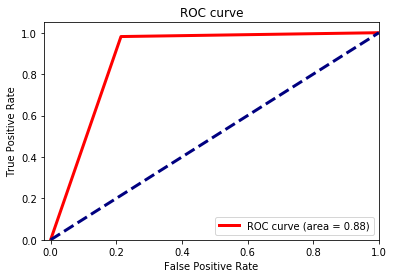

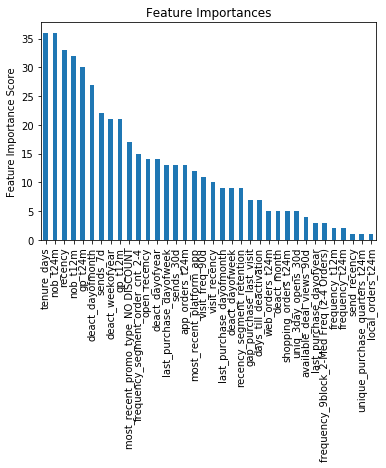

In [44]:
feat_imp = acc_calc(df_3[predictors], df_3[target], xgb1)

### NEXT ITERATION 2

In [45]:
least_favourable = list(pd.Series(feat_imp[-20:]).index)
print ("20 least important features:\n")
print (least_favourable)
not_predictors.extend(least_favourable)
predictors = [x for x in df_3.columns if x not in not_predictors]
print ("\nPredictors left: %i " %len(predictors))

20 least important features:

['most_recent_platform_app', 'visit_freq_90d', 'visit_recency', 'last_purchase_dayofmonth', 'deact_dayofweek', 'recency_segment_retention', 'gap_purchase_last_visit', 'days_till_deactivation', 'web_orders_t24m', 'deact_month', 'shopping_orders_t24m', 'uniq_3day_opens_30d', 'available_deal_views_90d', 'last_purchase_dayofyear', 'frequency_9block_2-Med Freq (2-4 Orders)', 'frequency_t12m', 'frequency_t24m', 'send_recency', 'unique_purchase_quarters_t24m', 'local_orders_t24m']

Predictors left: 75 


In [46]:
print("[",str(datetime.now()),"]",": Iteration 1 completed. Iteration 2 started...")

[ 2019-08-15 16:25:20.481778 ] : Iteration 1 completed. Iteration 2 started...


In [47]:
xgb1.fit(df_3[predictors], df_3[target], eval_metric='auc', verbose = False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0.05, learning_rate=0.1,
       max_delta_step=0, max_depth=6, min_child_weight=5, missing=None,
       n_estimators=1000, n_jobs=20, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=0.9, scale_pos_weight=1, seed=5, silent=1, subsample=0.8)


Model Report
Accuracy : 0.878
AUC Score (Train): 0.855820
Area under the precision-recall curve: 0.875500


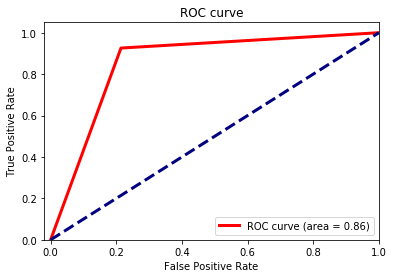

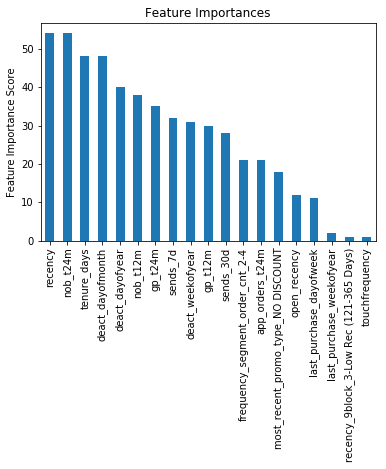

In [48]:
feat_imp = acc_calc(df_3[predictors], df_3[target], xgb1)

### FINAL TRAINING

In [49]:
least_favourable = list(pd.Series(feat_imp[-10:]).index)
print ("10 least important features:\n")
print (least_favourable)
not_predictors.extend(least_favourable)
predictors = [x for x in df_3.columns if x not in not_predictors]
print ("\nPredictors left: %i " %len(predictors))


10 least important features:

['gp_t12m', 'sends_30d', 'frequency_segment_order_cnt_2-4', 'app_orders_t24m', 'most_recent_promo_type_NO DISCOUNT', 'open_recency', 'last_purchase_dayofweek', 'last_purchase_weekofyear', 'recency_9block_3-Low Rec (121-365 Days)', 'touchfrequency']

Predictors left: 65 


In [50]:
print("[",str(datetime.now()),"]",": Iteration 2 completed. Iteration 3 started...")

[ 2019-08-15 16:37:37.558851 ] : Iteration 2 completed. Iteration 3 started...


In [51]:
predictors = [x for x in df_3.columns if x not in not_predictors]
not_pred = pd.DataFrame(not_predictors, columns = ["not_predictor"])
# not_pred.to_csv('not_pred.csv', index = False)
pred = pd.DataFrame(predictors, columns = ["predictor"])
# pred.to_csv('pred.csv', index = False)

In [52]:
print ("Predictors included in model: ", list(predictors))
print ("Predictors not included in model: ", list(not_predictors))

Predictors included in model:  ['tenure_days', 'recency', 'nob_t24m', 'gp_t24m', 'nob_t12m', 'travel_orders_t24m', 'touch_orders_t24m', 'is_activation', 'is_reactivation', 'visit_freq_7d', 'visit_freq_14d', 'visit_freq_28d', 'appfrequency', 'webfrequency', 'bcookies', 'sends_7d', 'uniq_3day_opens_7d', 'click_recency', 'uniq_3day_clicks_7d', 'uniq_3day_clicks_30d', 'unsubscription_30d', 'recency_segment_current_purchasers', 'recency_segment_lapsed_current_purchasers', 'recency_segment_lapsed_first_purchasers', 'recency_segment_pre-attrition', 'frequency_segment_order_cnt_1', 'frequency_segment_order_cnt_11-20', 'frequency_segment_order_cnt_20+', 'frequency_segment_order_cnt_5-10', 'recency_9block_1-High Rec (0-30 Days)', 'recency_9block_2-Med Rec (31-120 Days)', 'frequency_9block_1-Low Freq (1 Order)', 'frequency_9block_3-High Freq (5+ Orders)', 'most_recent_l1_L1 - Local', 'most_recent_l1_L1 - Shopping', 'most_recent_l1_L1 - Travel', 'most_recent_l1_other', 'most_recent_l1_unknown', 'm

In [53]:
xgb1 = XGBClassifier(
learning_rate =0.01,
n_estimators=5000,
max_depth=10,
min_child_weight=4,
gamma=0.05,
subsample=1,
colsample_bytree=1,
objective= 'binary:logistic',
n_jobs=20,
scale_pos_weight=1,
silent = 0,
seed=5)

xgb1.fit(df_3[predictors], df_3[target], eval_metric='auc', verbose = False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0.05, learning_rate=0.01,
       max_delta_step=0, max_depth=10, min_child_weight=4, missing=None,
       n_estimators=5000, n_jobs=20, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=5, silent=0, subsample=1)


Model Report
Accuracy : 0.9268
AUC Score (Train): 0.910053
Area under the precision-recall curve: 0.918570


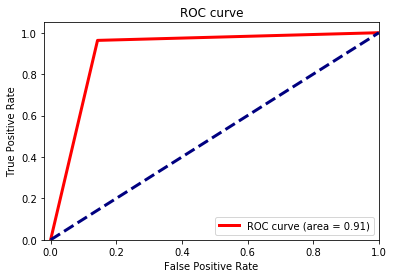

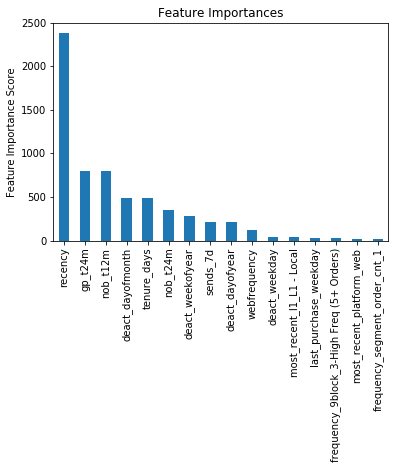

In [54]:
feat_imp = acc_calc(df_3[predictors], df_3[target], xgb1)

In [55]:
print("[",str(datetime.now()),"]",": Training completed. Saving the trained model...")

[ 2019-08-15 16:39:40.997321 ] : Training completed. Saving the trained model...


# Load Scoring Data

In [57]:
print("[",str(datetime.now()),"]",": Model saved. Reading prediction (scoring) data from cerebro...")

conn = hive.Connection(host="cerebro-hive-server1.snc1", port=10000, username="ceasterwood")
query ='''
select *
from grp_gdoop_clv_db.eb_pip_deact_all_features_scoring
where record_date = date_sub(current_date, -363)
limit 1000
'''

df_raw = pd.read_sql(query,conn)

print("[",str(datetime.now()),"]",": Prediction (scoring) data loaded. Feature engineering started...")

[ 2019-08-15 16:44:58.502218 ] : Model saved. Reading prediction (scoring) data from cerebro...
[ 2019-08-15 16:45:07.233027 ] : Prediction (scoring) data loaded. Feature engineering started...


In [58]:
df_raw.head()

,eb_pip_deact_all_features_scoring.brand,eb_pip_deact_all_features_scoring.consumer_id,eb_pip_deact_all_features_scoring.data_set,eb_pip_deact_all_features_scoring.recency_segment,eb_pip_deact_all_features_scoring.frequency_segment,eb_pip_deact_all_features_scoring.recency_9block,eb_pip_deact_all_features_scoring.frequency_9block,eb_pip_deact_all_features_scoring.deact_date,eb_pip_deact_all_features_scoring.next_order_date,eb_pip_deact_all_features_scoring.deact_flag,...,eb_pip_deact_all_features_scoring.sends_7d,eb_pip_deact_all_features_scoring.sends_30d,eb_pip_deact_all_features_scoring.open_recency,eb_pip_deact_all_features_scoring.uniq_3day_opens_7d,eb_pip_deact_all_features_scoring.uniq_3day_opens_30d,eb_pip_deact_all_features_scoring.click_recency,eb_pip_deact_all_features_scoring.uniq_3day_clicks_7d,eb_pip_deact_all_features_scoring.uniq_3day_clicks_30d,eb_pip_deact_all_features_scoring.unsubscription_30d,eb_pip_deact_all_features_scoring.record_date
0,groupon,0000eb32-78d8-11e4-8003-002590612862,validation,current_purchasers,order_cnt_2-4,1-High Rec (0-30 Days),2-Med Freq (2-4 Orders),2020-08-02,None,1,...,0,0,NaN,0,0,NaN,0,0,0,2020-08-12
1,groupon,00017314-e97d-11e1-b187-0025906127e4,training,current_purchasers,order_cnt_5-10,1-High Rec (0-30 Days),3-High Freq (5+ Orders),2020-07-27,None,1,...,8,34,11.0,0,4,NaN,0,0,0,2020-08-12
2,groupon,0001df40-00ed-11e5-925f-002590980646,training,retention,order_cnt_2-4,3-Low Rec (121-365 Days),2-Med Freq (2-4 Orders),2020-03-10,None,1,...,36,149,30.0,0,1,NaN,0,0,0,2020-08-12
3,groupon,00022820-3c5b-11e5-8106-002590980808,training,retention,order_cnt_2-4,3-Low Rec (121-365 Days),2-Med Freq (2-4 Orders),2019-11-21,None,1,...,33,122,NaN,0,0,NaN,0,0,0,2020-08-12
4,groupon,000276ce-24b5-11e2-8854-00259069d5fe,training,current_purchasers,order_cnt_11-20,1-High Rec (0-30 Days),3-High Freq (5+ Orders),2020-07-21,None,1,...,0,0,NaN,0,0,NaN,0,0,0,2020-08-12


In [59]:
df_raw = df_raw.rename(columns={col: col.split('.')[1] for col in df_raw.columns})

# Scoring Data Feature Engineeering

In [60]:
training_date = pd.Timestamp(df_raw.record_date.min())
print ("Prediction end date: ",training_date)
print (len(df_raw), " records loaded.")

Prediction end date:  2020-08-12 00:00:00
1000  records loaded.


In [61]:
col_list = df_raw.columns

In [62]:
df_raw = df_raw.drop(['record_date', 'brand'], axis = 1)

In [63]:
len(df_raw.columns)

51

In [64]:
#last visit date and last_purchase_date (deact_date - 365) working
df_raw.deact_date  = pd.to_datetime(df_raw.deact_date)
df_raw.last_visit_date  = pd.to_datetime(df_raw.last_visit_date)
# df_2.next_order_date = pd.to_datetime(df_2.next_order_date)

In [65]:
df_raw['last_purchase_date'] = df_raw['deact_date'].apply(lambda x: x - pd.DateOffset(years=1))

In [66]:
df_raw['gap_purchase_last_visit'] = (df_raw['last_visit_date'] - df_raw['last_purchase_date']).dt.days

In [67]:
df_raw['days_till_deactivation'] = (df_raw['deact_date'] - training_date).dt.days

In [68]:
#df_raw = df_raw.dropna(subset = ['deact_date', 'tenure_days'])
df_raw = df_raw.dropna(subset = ['deact_date'])

In [69]:
df_raw.describe()

,deact_flag,tenure_days,recency,frequency_t24m,nob_t24m,gp_t24m,frequency_t12m,nob_t12m,gp_t12m,local_orders_t24m,...,sends_30d,open_recency,uniq_3day_opens_7d,uniq_3day_opens_30d,click_recency,uniq_3day_clicks_7d,uniq_3day_clicks_30d,unsubscription_30d,gap_purchase_last_visit,days_till_deactivation
count,999.000000,686.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,...,999.000000,394.000000,999.000000,999.000000,188.000000,999.000000,999.000000,999.000000,573.000000,999.000000
mean,0.983984,2262.606414,528.224224,5.378378,209.313884,45.204791,2.865866,117.467097,25.976953,3.144144,...,89.325325,6.885787,1.928929,7.597598,10.734043,0.136136,0.504505,0.005005,93.280977,-163.224224
std,0.125600,884.541382,106.820762,8.731980,331.072841,69.381019,4.302214,175.083078,38.911527,3.937544,...,71.827974,8.345568,5.806322,21.974485,9.178183,0.515769,1.709261,0.083600,92.378570,106.820762
min,0.000000,851.000000,368.000000,1.000000,4.950000,-46.372400,0.000000,0.000000,-18.429100,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-61.000000,-633.000000
25%,1.000000,1425.500000,427.000000,1.000000,43.230000,9.289350,1.000000,28.980000,6.166400,1.000000,...,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,10.000000,-250.000000
50%,1.000000,2270.000000,525.000000,3.000000,105.000000,23.221400,1.000000,59.500000,13.617500,2.000000,...,129.000000,3.000000,0.000000,0.000000,8.500000,0.000000,0.000000,0.000000,67.000000,-160.000000
75%,1.000000,3051.000000,615.000000,6.000000,228.880000,53.616350,3.000000,128.000000,30.260550,4.000000,...,153.000000,11.750000,1.000000,3.000000,18.000000,0.000000,0.000000,0.000000,162.000000,-62.000000
max,1.000000,3932.000000,998.000000,159.000000,5053.100000,887.517200,64.000000,1544.900000,464.819300,31.000000,...,273.000000,30.000000,39.000000,151.000000,30.000000,6.000000,25.000000,2.000000,357.000000,-3.000000


In [70]:
col_list_3 = df_raw.columns

In [71]:
#solving NaN
df_raw['last_visit_date'] = df_raw['last_visit_date'].fillna(df_raw['last_purchase_date'] -  pd.to_timedelta(90, unit='d'))
df_raw = df_raw.fillna({'visit_recency':90, 'bcookies': 1, 'send_recency':30, 'open_recency':30, 'click_recency':30, 'gap_purchase_last_visit': 0})
df_raw['gap_purchase_last_visit'] = df_raw.gap_purchase_last_visit.clip_lower(0)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead
  after removing the cwd from sys.path.


In [72]:
len(list(df_raw.columns))

54

In [73]:
df_raw['deact_dayofmonth'] = df_raw.deact_date.dt.day
df_raw['deact_dayofyear'] = df_raw.deact_date.dt.dayofyear
df_raw['deact_dayofweek'] = df_raw.deact_date.dt.dayofweek
df_raw['deact_weekofyear'] = df_raw.deact_date.dt.weekofyear
df_raw['deact_month'] = df_raw.deact_date.dt.month
df_raw['deact_weekday'] = ((df_raw.deact_date.dt.dayofweek) // 5 == 1).astype(float)

In [74]:
df_raw['last_purchase_dayofmonth'] = df_raw.last_purchase_date.dt.day
df_raw['last_purchase_dayofyear'] = df_raw.last_purchase_date.dt.dayofyear
df_raw['last_purchase_dayofweek'] = df_raw.last_purchase_date.dt.dayofweek
df_raw['last_purchase_weekofyear'] = df_raw.last_purchase_date.dt.weekofyear
df_raw['last_purchase_month'] = df_raw.last_purchase_date.dt.month
df_raw['last_purchase_weekday'] = ((df_raw.last_purchase_date.dt.dayofweek) // 5 == 1).astype(float)

In [75]:
str(training_date.date())

'2020-08-12'

# Predicting Deact Probability

In [76]:
print("[",str(datetime.now()),"]",": Feature engineering completed. Predicting the deactivation probability...")

[ 2019-08-15 16:55:49.971833 ] : Feature engineering completed. Predicting the deactivation probability...


In [77]:
loaded_model = xgb1

In [78]:
loaded_model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0.05, learning_rate=0.01,
       max_delta_step=0, max_depth=10, min_child_weight=4, missing=None,
       n_estimators=5000, n_jobs=20, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=5, silent=0, subsample=1)

In [79]:
# df_val = df_raw.copy()
# df_val = pd.read_csv('cleaned_data_training_20180803.csv')
# df_2 = pd.read_csv('cleaned_data_validation_20180803.csv')

In [80]:
df_raw_cols = list(df_raw.columns)

In [81]:
df_raw.shape

(999, 66)

In [82]:
df_raw.deact_date.max()

Timestamp('2020-08-09 00:00:00')

In [83]:
df_raw.days_till_deactivation.max()

-3.0

In [86]:
missing_cols = np.setdiff1d(predictors, df_raw_cols)
missing_cols

array(['frequency_9block_1-Low Freq (1 Order)',
       'frequency_9block_3-High Freq (5+ Orders)',
       'frequency_segment_order_cnt_1',
       'frequency_segment_order_cnt_11-20',
       'frequency_segment_order_cnt_20+',
       'frequency_segment_order_cnt_5-10', 'most_recent_l1_L1 - Local',
       'most_recent_l1_L1 - Shopping', 'most_recent_l1_L1 - Travel',
       'most_recent_l1_other', 'most_recent_l1_unknown',
       'most_recent_l2_', 'most_recent_l2_L2 - Food & Drink',
       'most_recent_l2_L2 - Health / Beauty / Wellness',
       'most_recent_l2_L2 - Health, Beauty & Grocery',
       'most_recent_l2_L2 - Home', 'most_recent_l2_L2 - Home & Auto',
       'most_recent_l2_L2 - Hotel', 'most_recent_l2_L2 - Retail',
       'most_recent_l2_L2 - Softlines', 'most_recent_l2_L2 - Tech & Toys',
       'most_recent_l2_L2 - Things to Do - Leisure',
       'most_recent_l2_L2 - Things to Do - Live',
       'most_recent_l2_L2 - Tour', 'most_recent_l2_unknown',
       'most_recent_platform

In [85]:
for col in missing_cols:
    df_raw[col] = np.nan

In [87]:
df_raw

,consumer_id,data_set,recency_segment,frequency_segment,recency_9block,frequency_9block,deact_date,next_order_date,deact_flag,tenure_days,...,most_recent_promo_type_ILS,most_recent_promo_type_ILS+OD,most_recent_promo_type_OD,most_recent_promo_type_WOW,recency_9block_1-High Rec (0-30 Days),recency_9block_2-Med Rec (31-120 Days),recency_segment_current_purchasers,recency_segment_lapsed_current_purchasers,recency_segment_lapsed_first_purchasers,recency_segment_pre-attrition
0,0000eb32-78d8-11e4-8003-002590612862,validation,current_purchasers,order_cnt_2-4,1-High Rec (0-30 Days),2-Med Freq (2-4 Orders),2020-08-02,None,1,1368.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,00017314-e97d-11e1-b187-0025906127e4,training,current_purchasers,order_cnt_5-10,1-High Rec (0-30 Days),3-High Freq (5+ Orders),2020-07-27,None,1,3393.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0001df40-00ed-11e5-925f-002590980646,training,retention,order_cnt_2-4,3-Low Rec (121-365 Days),2-Med Freq (2-4 Orders),2020-03-10,None,1,1908.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,00022820-3c5b-11e5-8106-002590980808,training,retention,order_cnt_2-4,3-Low Rec (121-365 Days),2-Med Freq (2-4 Orders),2019-11-21,None,1,1352.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,000276ce-24b5-11e2-8854-00259069d5fe,training,current_purchasers,order_cnt_11-20,1-High Rec (0-30 Days),3-High Freq (5+ Orders),2020-07-21,None,1,3468.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0003acb2-78f5-11e2-b507-002590955678,training,lapsed_current_purchasers,order_cnt_2-4,2-Med Rec (31-120 Days),2-Med Freq (2-4 Orders),2020-05-23,None,1,2721.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,000457be-3e4a-11e3-b6d2-00259060b5be,training,recent_first_purchasers,order_cnt_1,1-High Rec (0-30 Days),1-Low Freq (1 Order),2020-08-08,None,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,00046824-26dd-11e2-8757-00259069d5fe,validation,lapsed_current_purchasers,order_cnt_2-4,2-Med Rec (31-120 Days),2-Med Freq (2-4 Orders),2020-04-22,None,1,3303.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,00046de0-133a-11e6-8ab5-002590e87748,validation,lapsed_current_purchasers,order_cnt_2-4,2-Med Rec (31-120 Days),2-Med Freq (2-4 Orders),2020-04-15,None,1,1559.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,00057eea-23a8-11e2-a837-00259069d5fe,validation,retention,order_cnt_11-20,3-Low Rec (121-365 Days),3-High Freq (5+ Orders),2020-02-07,None,1,2003.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [90]:
df_2 = loaded_model.predict_proba(df_raw[predictors])
df_2

array([[0.495943  , 0.504057  ],
       [0.4184056 , 0.5815944 ],
       [0.5512848 , 0.44871518],
       ...,
       [0.13263017, 0.86736983],
       [0.0531829 , 0.9468171 ],
       [0.35280025, 0.64719975]], dtype=float32)

In [91]:
y_prob_deact=np.array(df_2)[:,1]
y_prob_deact

array([0.504057  , 0.5815944 , 0.44871518, 0.94871473, 0.4918432 ,
       0.9327991 , 0.6261556 , 0.8468995 , 0.84881055, 0.1492336 ,
       0.92450094, 0.39321518, 0.6186382 , 0.6953684 , 0.6749447 ,
       0.89903957, 0.7362774 , 0.10759602, 0.9146401 , 0.56148195,
       0.92910266, 0.174606  , 0.9435256 , 0.8494079 , 0.93923706,
       0.6628065 , 0.97447485, 0.9149252 , 0.6488856 , 0.64002126,
       0.20432135, 0.9794989 , 0.6708953 , 0.9294909 , 0.93964905,
       0.51378757, 0.6924832 , 0.94400877, 0.91292137, 0.65659505,
       0.9785826 , 0.96646225, 0.86516786, 0.90914214, 0.9763039 ,
       0.5991487 , 0.12868702, 0.645329  , 0.50186646, 0.96433043,
       0.96500254, 0.91663337, 0.6677016 , 0.7661383 , 0.73088825,
       0.9206337 , 0.769914  , 0.8285485 , 0.86583513, 0.84827393,
       0.39895216, 0.6626659 , 0.814435  , 0.8993668 , 0.97547513,
       0.9500886 , 0.6473832 , 0.6596212 , 0.40157062, 0.9658902 ,
       0.7772149 , 0.22706391, 0.9423921 , 0.96800226, 0.90520

In [92]:
df_out_validation = pd.DataFrame(list(zip(df_raw['consumer_id'], df_raw['deact_date'], y_prob_deact)), columns=['consumer_id', 'Deact_date', 'Prob_deact'])
df_out_validation.head()

,consumer_id,Deact_date,Prob_deact
0,0000eb32-78d8-11e4-8003-002590612862,2020-08-02,0.504057
1,00017314-e97d-11e1-b187-0025906127e4,2020-07-27,0.581594
2,0001df40-00ed-11e5-925f-002590980646,2020-03-10,0.448715
3,00022820-3c5b-11e5-8106-002590980808,2019-11-21,0.948715
4,000276ce-24b5-11e2-8854-00259069d5fe,2020-07-21,0.491843


In [93]:
df_deact_sum = df_out_validation[['Deact_date','Prob_deact']]
df_deact_sum = df_deact_sum.groupby(df_deact_sum['Deact_date']).sum()
df_deact_sum.reset_index(inplace=True)
df_deact_sum.head()

,Deact_date,Prob_deact
0,2018-11-18,0.948463
1,2019-08-13,1.560836
2,2019-08-14,1.853920
3,2019-08-15,1.893448
4,2019-08-16,2.895115


# Save Off Results

In [94]:
print("[",str(datetime.now()),"]",": Prediction completed. Saving the output...")

[ 2019-08-15 17:03:18.276169 ] : Prediction completed. Saving the output...


In [95]:
#df_deact_sum.to_csv('/home/ebates/Forecast_deacts_agg_by_day.csv', index = False)

In [96]:
#df_out_validation.to_csv('/home/ebates/Deact_predicted_probability_by_customer.csv', index = False)

In [97]:
print("[",str(datetime.now()),"]",": Output saved. Pushing output to cerebro...")

[ 2019-08-15 17:04:58.609517 ] : Output saved. Pushing output to cerebro...


In [98]:
# Probability by customer copied to table: grp_gdoop_clv_db.eb_deact_predictions
# Then partitioned on date

In [99]:
# Num deact customers per day copied to table: grp_gdoop_clv_db.eb_deact_forecast
# Then partitioned on date

In [100]:
b = datetime.now()
print("[",str(datetime.now()),"]",": Output loaded to Hive table succesfully. Deactivation model prediction completed.")

[ 2019-08-15 17:07:52.987132 ] : Output loaded to Hive table succesfully. Deactivation model prediction completed.


In [101]:
print ("Total time taken:", (b-a))

Total time taken: 4:06:12.651374
